In [1]:
import sys
sys.path.append("/Users/amittaris/Documents/GitHub/plnn")
sys.path.append("/Users/amittaris/Documents/GitHub/plnn/plnn/models/algebraic_pl.py")

from plnn.models.algebraic_pl import *
from plnn.models.algebraic_potentials import *
from AE_equinox import *
from VAE_equinox import *
import jax
import jax.numpy as jnp
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
phi_model = QuadraticPotential(a=2.0, b=3.0)

key = jax.random.PRNGKey(0)
num_points = 10000
dim = 2  # Must match the implementation of QuadraticPotential

# Sample 2D points
points = jax.random.normal(key, shape=(num_points, dim))

# Vectorized evaluation
phi_val = jax.vmap(phi_model.phi)(points)
grad_val = jax.vmap(phi_model.grad_phi)(points)

print("φ(x) =", phi_val[0])
print("∇φ(x) =", grad_val[0])

collected_values = jnp.column_stack((points, phi_val))



φ(x) = 17.571026
∇φ(x) = [ 6.4905686 12.151588 ]


In [3]:
print(points[:, 1])

[ 2.0252647  -0.07861735 -0.97208923 ... -1.0343567  -1.1525683
  1.0966566 ]


In [4]:
# Plot
fig = go.Figure(data=go.Scatter3d(
    x=collected_values[:, 0], y=collected_values[:, 1], z=collected_values[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        colorscale='Viridis',
        opacity=0.9
    )
))

fig.show()

In [ ]:
model = DeepAutoencoder(key, latent_dim=2, input_dim=3)

trained_AE = train_AE(
    model,
    loss_fn=loss2_AE,
    X=collected_values,         # jnp.ndarray of shape (N, D)
    steps=2000,
    batch_size=128,
    learning_rate=1e-3,
    print_every=1000
)

step=0, loss=16.9423
step=1000, loss=0.0573
step=1999, loss=0.0363


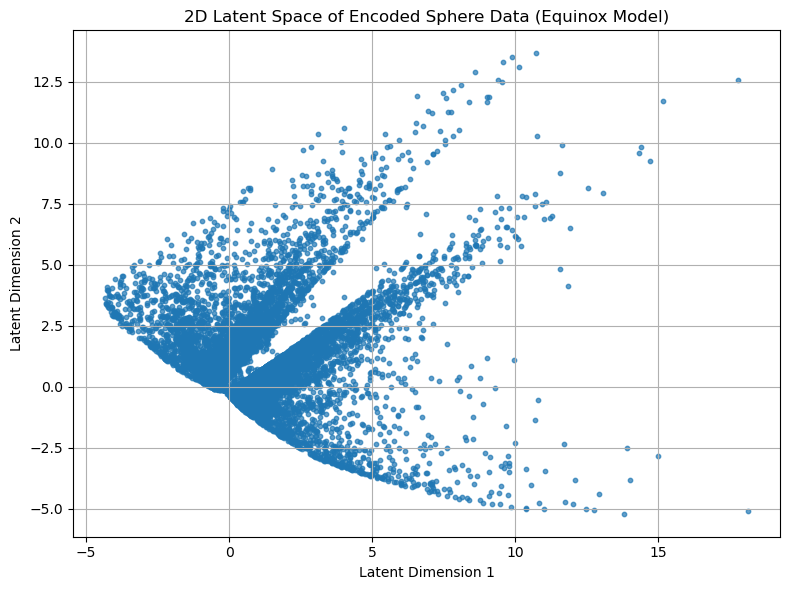

In [7]:
# Step 1: Encode test data using the trained Equinox model
# Assuming trained_model is the model returned by train_model
# Assuming X_test_jax contains the test data as a jnp.ndarray

encoded_latents = jax.vmap(trained_AE.encode)(collected_values)

# Move the encoded data to CPU
encoded_latents_cpu = jax.device_get(encoded_latents)

# Extract the 2D coordinates
x_coords = encoded_latents_cpu[:, 1]
y_coords = encoded_latents_cpu[:, 0]

# Step 2: Plot the latent space
plt.figure(figsize=(8, 6))

# Assuming 'labels' from the data generation cell (TRdTDVJrTSfQ) is still available
# and corresponds to the original full dataset X.
# We need to filter these labels to match the X_test_jax data.
# Assuming X_test_jax was created by splitting the original X based on indices.
# We need to apply the same split to the labels.

# Re-applying the split logic to labels based on the saved indices
# Assumes the indices and split_idx from the previous cell (oIEcelt21ZeX) are available
# If not, you might need to re-run or store them.
# For now, let's assume they are available and we can use them to get the test labels.
try:
    labels_test = labels[indices[split_idx:]]
    scatter = plt.scatter(x_coords, y_coords, c=labels_test, cmap='viridis', alpha=0.7, s=10)
    plt.colorbar(scatter, label='Data Label')
except NameError:
    print("Warning: 'labels', 'indices', or 'split_idx' not found. Plotting without color coding.")
    scatter = plt.scatter(x_coords, y_coords, alpha=0.7, s=10)


plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Latent Space of Encoded Sphere Data (Equinox Model)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
key = jax.random.PRNGKey(0)  # or any other seed
model = DeepVAE(key, latent_dim=2, input_dim=3)

trained_VAE = train_VAE(
    model=model,
    loss_fn=loss2_VAE,
    X=collected_values,
    steps=200000,
    batch_size=128,
    learning_rate=1e-3,
    print_every=50000
)


step=0, loss=16.8861
step=50000, loss=1.2693
step=100000, loss=1.2203
step=150000, loss=1.1362
step=199999, loss=1.2204


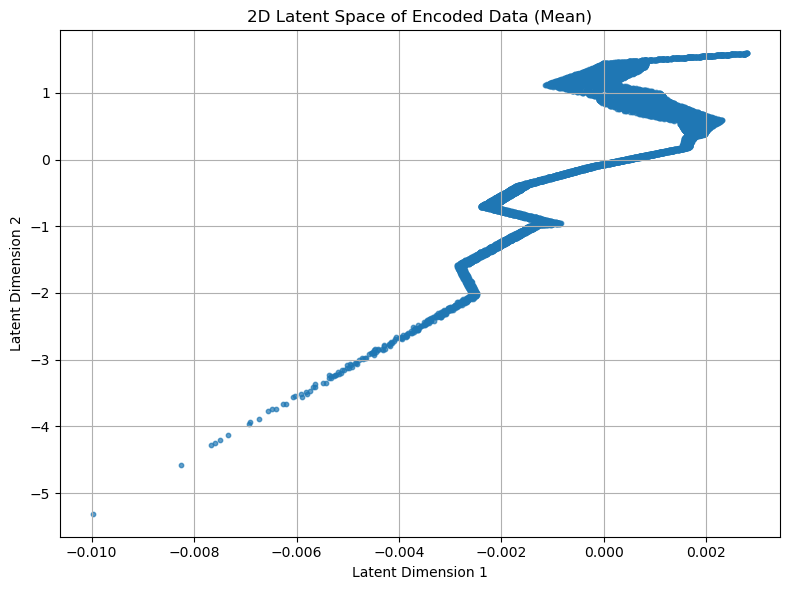

In [8]:
# Unpack the tuple returned from encode
mu, sigma = jax.vmap(trained_VAE.encode)(collected_values)
mu = jax.device_get(mu)

x_coords = mu[:, 0]
y_coords = mu[:, 1]

# Step 2: Plot the 2D latent space
plt.figure(figsize=(8, 6))

try:
    labels_train = labels[indices[:split_idx]]
    scatter = plt.scatter(x_coords, y_coords, c=labels_train, cmap='viridis', alpha=0.7, s=10)
    plt.colorbar(scatter, label='Label')
except NameError:
    print("Warning: 'labels', 'indices', or 'split_idx' not found. Plotting without label colors.")
    plt.scatter(x_coords, y_coords, alpha=0.7, s=10)

plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Latent Space of Encoded Data (Mean)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# 1. Key
key = jax.random.PRNGKey(0)

# 2. Create the phi module
phi = QuadraticPotential(a=1.0, b=1.0)

# 3. Instantiate the AlgebraicPL model
model = AlgebraicPL(
    key=key,
    ndims=2,
    nparams=2,
    nsigs=2,
    ncells=100,
    signal_type='jump',
    nsigparams=3,
    sigma_init=1e-2,
    solver='euler',
    dt0=1e-2,
    vbt_tol=1e-6,
    sample_cells=True,
    phi_module=phi,
    include_tilt_bias=True,
    algebraic_phi_id=None,
    tilt_weights=None,
    tilt_bias=None,
    phi_args={},
)



In [12]:
key0, key1 = jax.random.split(jax.random.PRNGKey(0))
phi = QuadraticPotential(a=1.0, b=1.0)

model, hps = AlgebraicPL.make_model(
    key=key0,
    dtype=jnp.float32,
    ndims=2, nparams=2, nsigs=2,
    ncells=100, signal_type='jump', nsigparams=3,
    sigma_init=1e-2, solver='euler', dt0=1e-2, vbt_tol=1e-6,
    sample_cells=True,
    phi_module=phi,              # set module explicitly
    algebraic_phi_id=None,       # ignored if phi_module is given
    include_tilt_bias=True,
    tilt_weights=None, tilt_bias=None,
    phi_args={},
)
model = model.initialize(key1, dtype=jnp.float32)


In [10]:
def simulate_algebraic_pl(model, y0, s, t_max=5.0, dt=0.01):
    """
    Simulate the trajectory of the AlgebraicPL system using explicit Euler method.

    Args:
        model: An instance of AlgebraicPL.
        y0 (jnp.ndarray): Initial state, shape (ndims,).
        s (jnp.ndarray): Signal input, shape (nparams,).
        t_max (float): Total simulation time.
        dt (float): Time step.

    Returns:
        jnp.ndarray: Trajectory of shape (steps+1, ndims).
    """
    steps = int(t_max / dt)
    y = y0
    trajectory = [y0]

    for _ in range(steps):
        grad_phi = model.eval_grad_phi(0.0, y)
        tilt = model.tilt_module(s)
        dy = -grad_phi + tilt  # basic deterministic dynamics
        y = y + dt * dy
        trajectory.append(y)

    return jnp.stack(trajectory)


In [11]:

y0 = jnp.array([2.0, 2.0])
s = jnp.array([1.0, -1.0])

trajectory = simulate_algebraic_pl(model, y0, s, t_max=5.0)

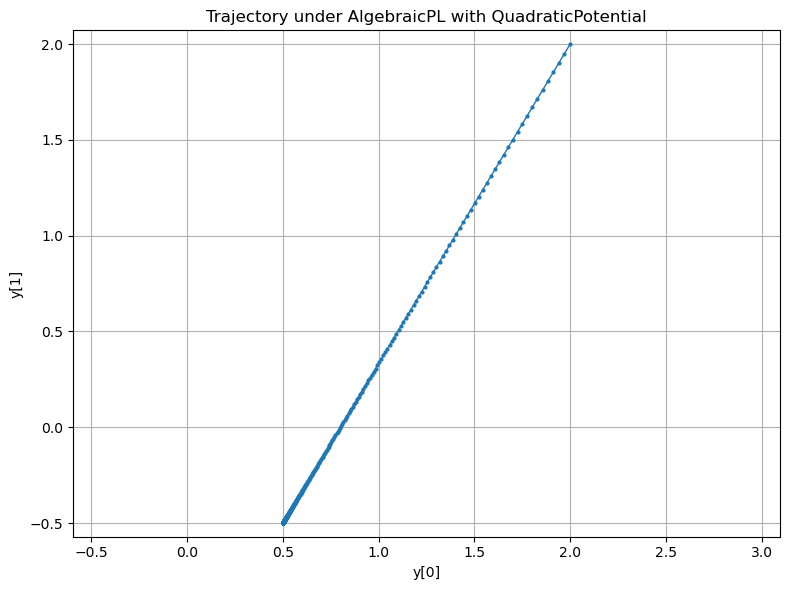

In [12]:

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', markersize=2, linewidth=1)
plt.title("Trajectory under AlgebraicPL with QuadraticPotential")
plt.xlabel("y[0]")
plt.ylabel("y[1]")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the quadratic potential
def phi(y, a=1.0, b=1.0):
    return 0.5 * (a * y[0]**2 + b * y[1]**2)

def grad_phi(y, a=1.0, b=1.0):
    return np.array([a * y[0], b * y[1]])

# Compute potential surface
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = 0.5 * (X**2 + Y**2)

# Compute trajectory height (potential value)
traj_z = np.array([phi(p) for p in trajectory])
traj_x = trajectory[:, 0]
traj_y = trajectory[:, 1]

import plotly.graph_objects as go
import numpy as np

# Assume you have these already computed:
# X, Y, Z: the potential surface meshgrid
# traj_x, traj_y, traj_z: trajectory coordinates

# Convert to numpy for Plotly compatibility
X_np = np.array(X)
Y_np = np.array(Y)
Z_np = np.array(Z)
traj_x_np = np.array(traj_x)
traj_y_np = np.array(traj_y)
traj_z_np = np.array(traj_z)

# Create the surface plot of the potential
surface = go.Surface(x=X_np, y=Y_np, z=Z_np, colorscale='Viridis', opacity=0.6)

# Create the trajectory plot
trajectory = go.Scatter3d(
    x=traj_x_np,
    y=traj_y_np,
    z=traj_z_np,
    mode='lines+markers',
    line=dict(color='red', width=4),
    marker=dict(size=3),
    name='Trajectory'
)

# Combine and plot
fig = go.Figure(data=[surface, trajectory])
fig.update_layout(
    title="Trajectory on Potential Surface",
    scene=dict(
        xaxis_title="y[0]",
        yaxis_title="y[1]",
        zaxis_title="Φ(y)"
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    width=900,
    height=700
)

fig.show()



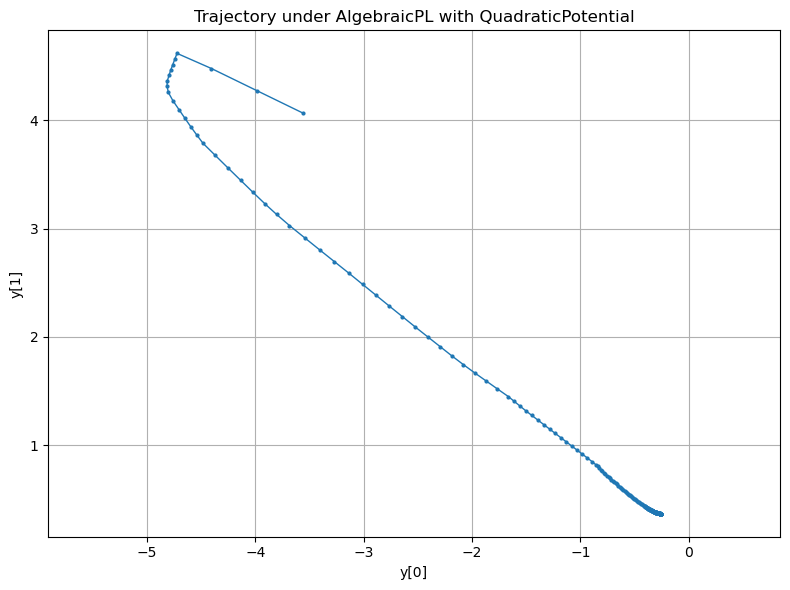

In [78]:
y0 = jnp.array([2.0, 2.0])
s = jnp.array([1.0, -1.0])

trajectory = simulate_algebraic_pl(model, y0, s, t_max=5.0)
traj_x = trajectory[:, 0]
traj_y = trajectory[:, 1]
traj_phi = traj_z  # Already shape (501,)

values = values = jnp.stack([traj_x, traj_y, traj_z], axis=0).T  # shape: (501, 3)

encoded_latents = jax.vmap(trained_AE.encode)(values)


# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(encoded_latents[:, 0], encoded_latents[:, 1], marker='o', markersize=2, linewidth=1)
plt.title("Trajectory under AlgebraicPL with QuadraticPotential")
plt.xlabel("y[0]")
plt.ylabel("y[1]")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()

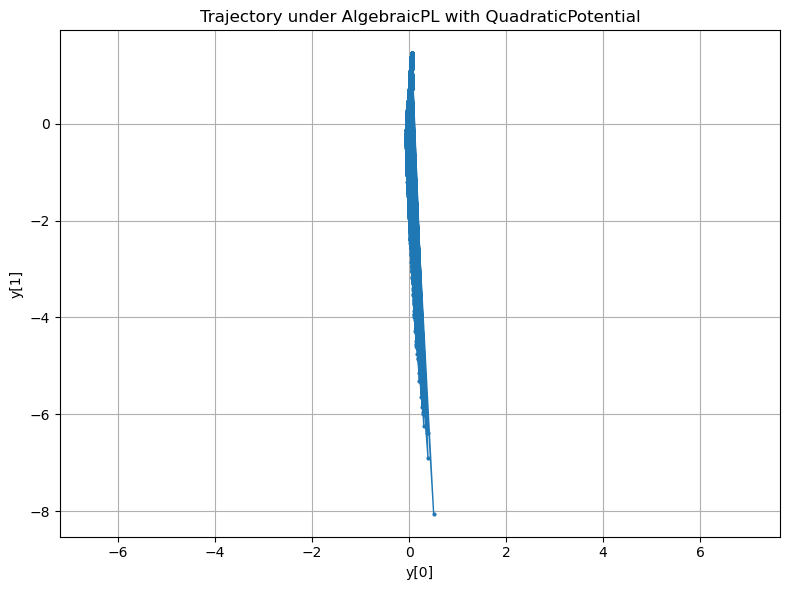

In [79]:
y0 = jnp.array([2.0, 2.0])
s = jnp.array([1.0, -1.0])

trajectory = simulate_algebraic_pl(model, y0, s, t_max=5.0)
traj_x = trajectory[:, 0]
traj_y = trajectory[:, 1]
traj_phi = traj_z  # Already shape (501,)

values = values = jnp.stack([traj_x, traj_y, traj_z], axis=0).T  # shape: (501, 3)

mu, sigma = jax.vmap(trained_VAE.encode)(collected_values)


# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(mu[:, 0], mu[:, 1], marker='o', markersize=2, linewidth=1)
plt.title("Trajectory under AlgebraicPL with QuadraticPotential")
plt.xlabel("y[0]")
plt.ylabel("y[1]")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()

In [8]:
# 1. PRNG key
key = jax.random.PRNGKey(0)

# 2. Define φ(y) = a*y₀² + b*y₁²
phi = QuadraticPotential(a=1.0, b=1.0)

# 3. Use make_model instead of __init__
model_NN, hyperparams = AlgebraicPL.make_model(
    key=key,
    ndims=2,
    nparams=2,
    nsigs=2,
    ncells=100,
    signal_type='jump',
    nsigparams=3,
    sigma_init=1e-2,
    solver='euler',
    dt0=1e-2,
    vbt_tol=1e-6,
    sample_cells=True,
    include_tilt_bias=True,
    tilt_hidden_dims=[32, 32],
    tilt_hidden_acts=[jax.nn.relu, jax.nn.relu],
    tilt_final_act=jax.nn.tanh,
    tilt_weights=None,
    tilt_bias=None,
    phi_module=phi,
    algebraic_phi_id=None,
    phi_args={}
)
